In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import joblib

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")


In [2]:
df = pd.read_csv(r"D:\6-Data Sets\Employers_data.csv")
df.head()


,Employee_ID,Name,Age,Gender,Department,Job_Title,Experience_Years,Education_Level,Location,Salary
0,1,Merle Ingram,24,Female,Engineering,Engineer,1,Master,Austin,90000
1,2,John Mayes,56,Male,Sales,Executive,33,Master,Seattle,195000
2,3,Carlos Wille,21,Male,Engineering,Intern,1,Bachelor,New York,35000
3,4,Michael Bryant,30,Male,Finance,Analyst,9,Bachelor,New York,75000
4,5,Paula Douglas,25,Female,HR,Analyst,2,Master,Seattle,70000


In [3]:
print(df.shape)
print(df.info())
print(df.describe())


(10000, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Employee_ID       10000 non-null  int64 
 1   Name              10000 non-null  object
 2   Age               10000 non-null  int64 
 3   Gender            10000 non-null  object
 4   Department        10000 non-null  object
 5   Job_Title         10000 non-null  object
 6   Experience_Years  10000 non-null  int64 
 7   Education_Level   10000 non-null  object
 8   Location          10000 non-null  object
 9   Salary            10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB
None
       Employee_ID           Age  Experience_Years         Salary
count  10000.00000  10000.000000      10000.000000   10000.000000
mean    5000.50000     35.455900         12.370900  115381.500000
std     2886.89568     10.000213          9.148951   46066.139047
min    

In [4]:
print(df.isnull().sum())
df.dropna(inplace=True)

print("Duplicates:", df.duplicated().sum())
df.drop_duplicates(inplace=True)

print("Final Shape:", df.shape)


Employee_ID         0
Name                0
Age                 0
Gender              0
Department          0
Job_Title           0
Experience_Years    0
Education_Level     0
Location            0
Salary              0
dtype: int64
Duplicates: 0
Final Shape: (10000, 10)


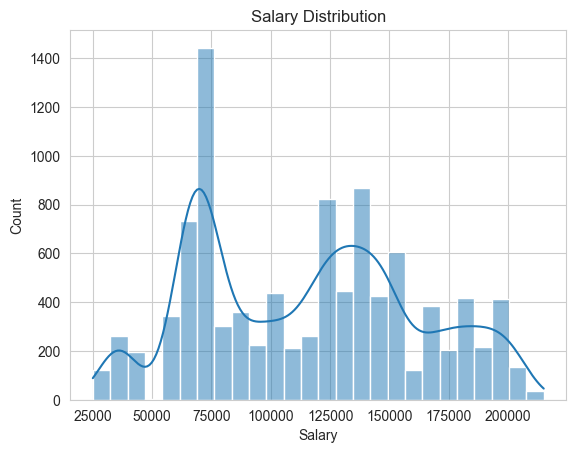

In [5]:
# Salary Distribution
sns.histplot(df['Salary'], kde=True)
plt.title("Salary Distribution")
plt.show()

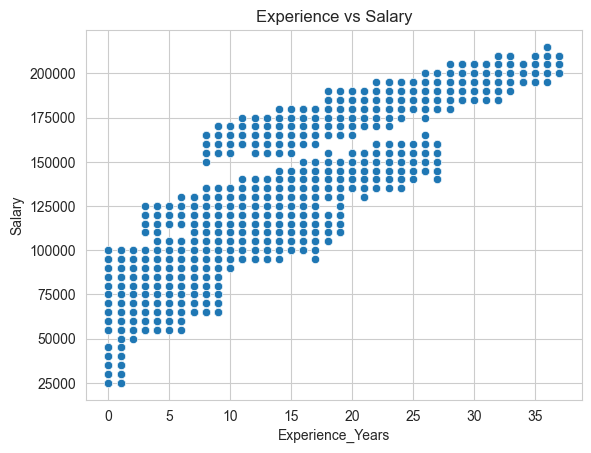

In [6]:
# Experience vs Salary
sns.scatterplot(x='Experience_Years', y='Salary', data=df)
plt.title("Experience vs Salary")
plt.show()

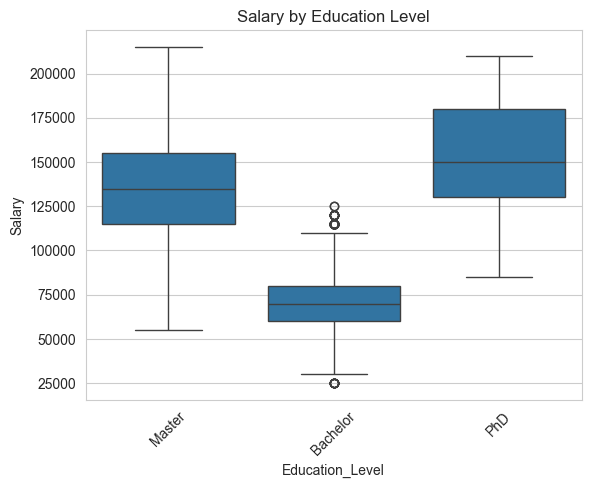

In [7]:
# Education vs Salary
sns.boxplot(x='Education_Level', y='Salary', data=df)
plt.xticks(rotation=45)
plt.title("Salary by Education Level")
plt.show()

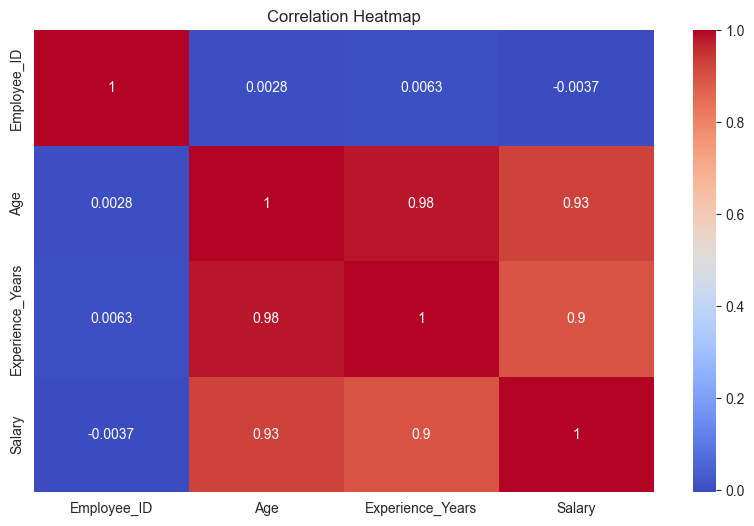

In [8]:
# Correlation
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [9]:
X = df.drop('Salary', axis=1)
y = df['Salary']


In [11]:
categorical_cols = X.select_dtypes(include='object').columns
numeric_cols = X.select_dtypes(exclude='object').columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [13]:
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])


In [14]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])


In [15]:
lr_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

In [16]:
def evaluate(name, model):
    preds = model.predict(X_test)
    print(f"\n{name}")
    print("R2:", r2_score(y_test, preds))
    print("MAE:", mean_absolute_error(y_test, preds))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))

evaluate("Linear Regression", lr_pipeline)
evaluate("Random Forest", rf_pipeline)



Linear Regression
R2: 0.9899290150849896
MAE: 3683.2636725971515
RMSE: 4607.193521548335

Random Forest
R2: 0.9907642727782143
MAE: 3513.675
RMSE: 4412.005354711166


In [17]:
best_model = rf_pipeline
joblib.dump(best_model, "employee_salary_model.pkl")

print("✅ Model saved successfully")


✅ Model saved successfully


In [18]:
import streamlit as st
import pandas as pd
import joblib

model = joblib.load("employee_salary_model.pkl")

st.title("💼 Employee Salary Prediction App")

st.write("Predict employee salary based on profile details")

age = st.number_input("Age", 18, 60)
experience = st.number_input("Experience (Years)", 0, 40)
education = st.selectbox("Education Level", ["Bachelor", "Master", "PhD"])
job_title = st.selectbox("Job Title", ["Analyst", "Manager", "Engineer"])
gender = st.selectbox("Gender", ["Male", "Female"])

if st.button("Predict Salary"):
    input_df = pd.DataFrame({
        "Age": [age],
        "Experience_Years": [experience],
        "Education_Level": [education],
        "Job_Title": [job_title],
        "Gender": [gender]
    })

    salary = model.predict(input_df)[0]
    st.success(f"💰 Predicted Salary: ₹ {salary:,.2f}")


2025-12-19 13:28:29.238 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 13:28:29.786 
  command:

    streamlit run C:\Users\santh\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-12-19 13:28:29.787 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 13:28:29.788 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 13:28:29.789 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 13:28:29.790 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 13:28:29.791 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 13:28:

# XGBoost :

In [19]:
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(include=['int64','float64']).columns


In [20]:
from xgboost import XGBRegressor
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', 'passthrough', num_cols)
])

model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', model)
])


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [22]:
pipeline.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [23]:
y_pred = pipeline.predict(X_test)

print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


R2 Score: 0.9913485646247864
MAE: 3417.1123046875
RMSE: 4270.165102194527


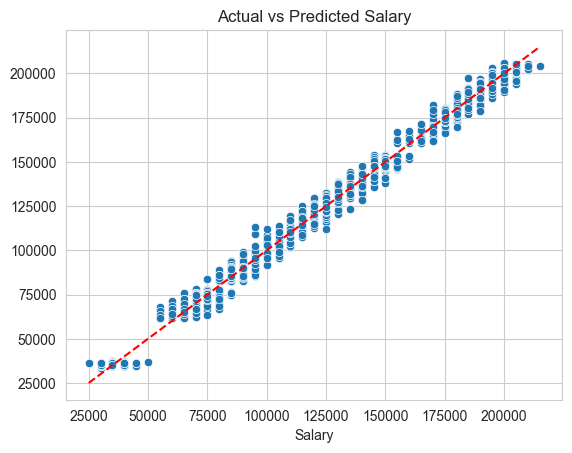

In [24]:
# Actual vs Predicted Plot
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.title("Actual vs Predicted Salary")
plt.show()


In [25]:
joblib.dump(pipeline, "best_salary_xgb.pkl")
joblib.dump(X.columns.tolist(), "model_columns.pkl")

print("✅ XGBoost model saved successfully")


✅ XGBoost model saved successfully


In [26]:
import streamlit as st
import pandas as pd
import joblib

model = joblib.load("best_salary_xgb.pkl")

st.set_page_config(page_title="Employee Salary Prediction", layout="centered")
st.title("💼 Employee Salary Prediction (XGBoost)")

st.write("Predict employee salary based on experience, role & education")

# ---- User Inputs ----
age = st.number_input("Age", 18, 65)
experience = st.number_input("Years of Experience", 0, 40)
gender = st.selectbox("Gender", ["Male", "Female"])
education = st.selectbox("Education Level", ["Bachelor", "Master", "PhD"])
job_title = st.text_input("Job Title")
department = st.text_input("Department")

# ---- Create DataFrame ----
input_df = pd.DataFrame({
    "Age": [age],
    "Experience_Years": [experience],
    "Gender": [gender],
    "Education_Level": [education],
    "Job_Title": [job_title],
    "Department": [department]
})

if st.button("Predict Salary"):
    prediction = model.predict(input_df)
    st.success(f"💰 Predicted Salary: ₹ {prediction[0]:,.2f}")


2025-12-19 13:28:58.026 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 13:28:58.028 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 13:28:58.029 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 13:28:58.030 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 13:28:58.032 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 13:28:58.034 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 13:28:58.037 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 13:28:58.039 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar